In [1]:
# Step 1: Setup - Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Step 2: Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 3: Data Augmentation and Normalization for Training
# Just Normalization for Validation and Test
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # assuming RGB images
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Step 4: Load Datasets
train_dir = 'train'
val_dir = 'validation'
test_dir = 'test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Step 5: Create DataLoaders
# Batch size will be changed later depending on the experiment
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 6: Check Class Labels
print("Classes:", train_dataset.classes)


Using device: cuda
Classes: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']


In [2]:
# Step 2: Define Basic CNN Model (without Residual Connections)

class BasicCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(BasicCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Conv Layer 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer 5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)) # Global average pooling
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)
        return x

# Instantiate the model
basic_cnn = BasicCNN(num_classes=11).to(device)
print(basic_cnn)


BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [3]:
# Step 3: Define CNN Model with Residual Connections

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            identity = self.downsample(identity)
        
        out += identity
        out = self.relu(out)
        
        return out

class ResidualCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(ResidualCNN, self).__init__()
        
        self.layer1 = ResidualBlock(3, 32)
        self.layer2 = ResidualBlock(32, 64, downsample=True)
        self.layer3 = ResidualBlock(64, 128, downsample=True)
        self.layer4 = ResidualBlock(128, 256, downsample=True)
        self.layer5 = ResidualBlock(256, 512, downsample=True)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model
residual_cnn = ResidualCNN(num_classes=11).to(device)
print(residual_cnn)


ResidualCNN(
  (layer1): ResidualBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [4]:
# Step 4: Define Loss Function and Accuracy Metric

criterion = nn.CrossEntropyLoss()

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

# Step 5: Training and Validation Functions

def train_one_epoch(model, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = calculate_accuracy(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_acc += acc * inputs.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_acc += acc * inputs.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc


In [8]:
# Step 5.1: Train Model Across Epochs

def train_model(model, train_loader, val_loader, learning_rate, num_epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, device)
        val_loss, val_acc = evaluate(model, val_loader, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Yeni: her epoch yazdıracak
        print(f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} "
            f"Train Acc: {train_acc:.4f} Val Acc: {val_acc:.4f}")

            
    return train_losses, val_losses, train_accuracies, val_accuracies


In [6]:
# Step 5.2: Plot Loss and Accuracy Graphs

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title_suffix=''):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12,5))
    
    # Loss Plot
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title(f'Loss vs Epochs {title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title(f'Accuracy vs Epochs {title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()



Training BasicCNN with batch_size=32, lr=0.1
Epoch [1/50] Train Loss: 6.3377 Val Loss: 2.5824 Train Acc: 0.0950 Val Acc: 0.0836
Epoch [2/50] Train Loss: 2.4101 Val Loss: 2.4229 Train Acc: 0.0823 Val Acc: 0.0909
Epoch [3/50] Train Loss: 2.4109 Val Loss: 2.4035 Train Acc: 0.1000 Val Acc: 0.0909
Epoch [4/50] Train Loss: 2.4073 Val Loss: 2.4060 Train Acc: 0.0905 Val Acc: 0.0909
Epoch [5/50] Train Loss: 2.4092 Val Loss: 2.4057 Train Acc: 0.0823 Val Acc: 0.0909
Epoch [6/50] Train Loss: 2.4082 Val Loss: 2.4166 Train Acc: 0.0923 Val Acc: 0.0909
Epoch [7/50] Train Loss: 2.4080 Val Loss: 2.4100 Train Acc: 0.0868 Val Acc: 0.0909
Epoch [8/50] Train Loss: 2.4100 Val Loss: 2.4069 Train Acc: 0.0886 Val Acc: 0.0909
Epoch [9/50] Train Loss: 2.4135 Val Loss: 2.4023 Train Acc: 0.0755 Val Acc: 0.0909
Epoch [10/50] Train Loss: 2.4088 Val Loss: 2.4020 Train Acc: 0.0936 Val Acc: 0.0909
Epoch [11/50] Train Loss: 2.4125 Val Loss: 2.4109 Train Acc: 0.0909 Val Acc: 0.0909
Epoch [12/50] Train Loss: 2.4139 Val Lo

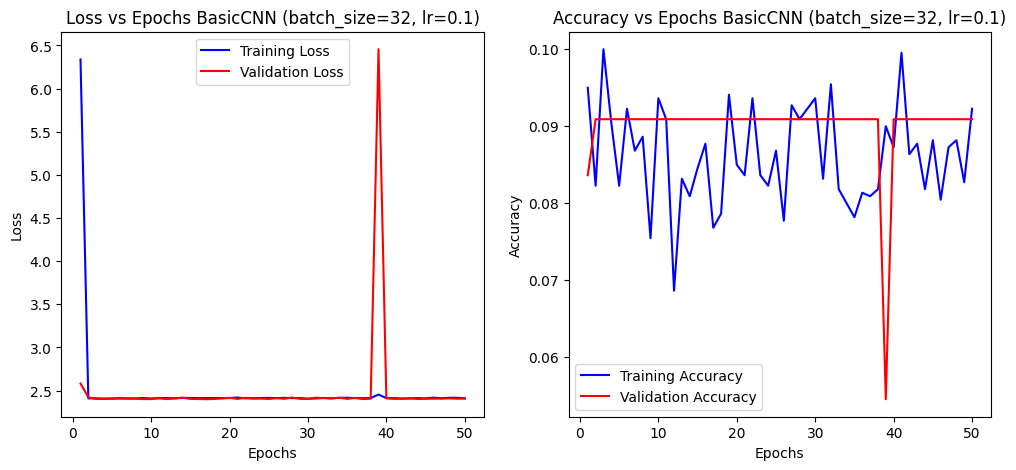


Training ResidualCNN with batch_size=32, lr=0.1
Epoch [1/50] Train Loss: 6.6042 Val Loss: 2.4052 Train Acc: 0.0950 Val Acc: 0.0873
Epoch [2/50] Train Loss: 2.4131 Val Loss: 2.4079 Train Acc: 0.0945 Val Acc: 0.0909
Epoch [3/50] Train Loss: 2.4078 Val Loss: 2.4123 Train Acc: 0.0900 Val Acc: 0.0909
Epoch [4/50] Train Loss: 2.4194 Val Loss: 2.4217 Train Acc: 0.0927 Val Acc: 0.0909
Epoch [5/50] Train Loss: 2.4135 Val Loss: 2.4172 Train Acc: 0.0814 Val Acc: 0.0909
Epoch [6/50] Train Loss: 2.4184 Val Loss: 2.4042 Train Acc: 0.0718 Val Acc: 0.0909
Epoch [7/50] Train Loss: 2.4175 Val Loss: 2.4073 Train Acc: 0.0850 Val Acc: 0.0909
Epoch [8/50] Train Loss: 2.4116 Val Loss: 2.4190 Train Acc: 0.0895 Val Acc: 0.0909
Epoch [9/50] Train Loss: 2.4130 Val Loss: 2.4042 Train Acc: 0.0900 Val Acc: 0.0909
Epoch [10/50] Train Loss: 2.4111 Val Loss: 2.4072 Train Acc: 0.0932 Val Acc: 0.0909
Epoch [11/50] Train Loss: 2.4142 Val Loss: 2.4153 Train Acc: 0.0973 Val Acc: 0.0909
Epoch [12/50] Train Loss: 2.4150 Val

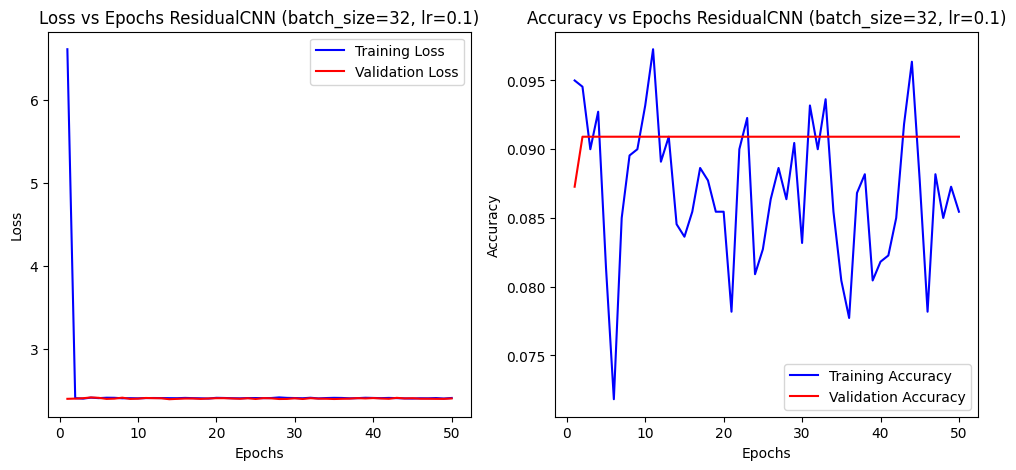


Training BasicCNN with batch_size=32, lr=0.01
Epoch [1/50] Train Loss: 2.4296 Val Loss: 2.3301 Train Acc: 0.1386 Val Acc: 0.1745
Epoch [2/50] Train Loss: 2.2866 Val Loss: 2.3186 Train Acc: 0.1750 Val Acc: 0.1273
Epoch [3/50] Train Loss: 2.2350 Val Loss: 2.4257 Train Acc: 0.1927 Val Acc: 0.1855
Epoch [4/50] Train Loss: 2.2039 Val Loss: 2.3629 Train Acc: 0.2145 Val Acc: 0.1709
Epoch [5/50] Train Loss: 2.1975 Val Loss: 2.3160 Train Acc: 0.2236 Val Acc: 0.1855
Epoch [6/50] Train Loss: 2.1686 Val Loss: 2.2125 Train Acc: 0.2414 Val Acc: 0.1855
Epoch [7/50] Train Loss: 2.1324 Val Loss: 2.1862 Train Acc: 0.2386 Val Acc: 0.2073
Epoch [8/50] Train Loss: 2.1267 Val Loss: 2.2961 Train Acc: 0.2577 Val Acc: 0.2255
Epoch [9/50] Train Loss: 2.0852 Val Loss: 2.1250 Train Acc: 0.2627 Val Acc: 0.2509
Epoch [10/50] Train Loss: 2.0450 Val Loss: 2.1091 Train Acc: 0.2850 Val Acc: 0.2764
Epoch [11/50] Train Loss: 2.0225 Val Loss: 2.3586 Train Acc: 0.2864 Val Acc: 0.2218
Epoch [12/50] Train Loss: 1.9909 Val L

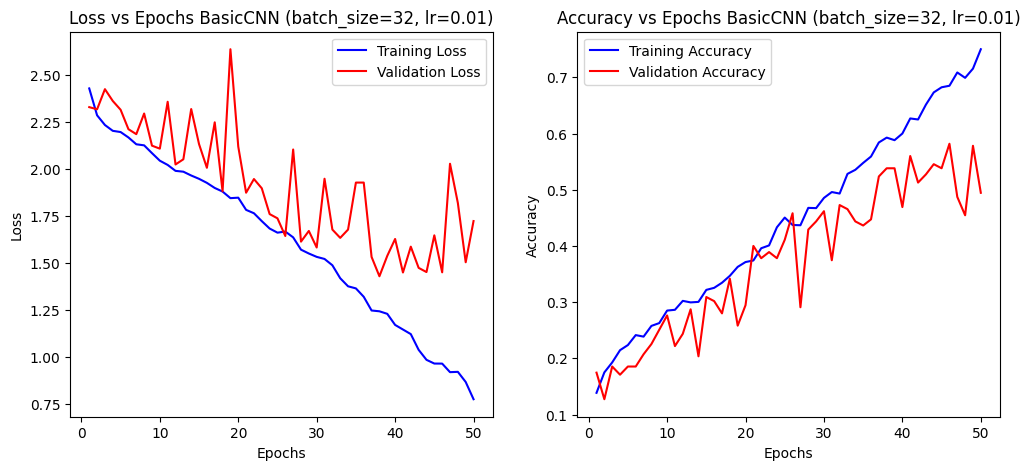


Training ResidualCNN with batch_size=32, lr=0.01
Epoch [1/50] Train Loss: 2.4850 Val Loss: 2.4279 Train Acc: 0.1200 Val Acc: 0.1236
Epoch [2/50] Train Loss: 2.3102 Val Loss: 2.3909 Train Acc: 0.1468 Val Acc: 0.1455
Epoch [3/50] Train Loss: 2.2727 Val Loss: 2.2950 Train Acc: 0.1723 Val Acc: 0.1309
Epoch [4/50] Train Loss: 2.2564 Val Loss: 2.2391 Train Acc: 0.1900 Val Acc: 0.1855
Epoch [5/50] Train Loss: 2.2282 Val Loss: 2.2155 Train Acc: 0.2036 Val Acc: 0.2145
Epoch [6/50] Train Loss: 2.2148 Val Loss: 2.2103 Train Acc: 0.2132 Val Acc: 0.2327
Epoch [7/50] Train Loss: 2.1745 Val Loss: 2.2224 Train Acc: 0.2377 Val Acc: 0.2145
Epoch [8/50] Train Loss: 2.1562 Val Loss: 2.1130 Train Acc: 0.2341 Val Acc: 0.3127
Epoch [9/50] Train Loss: 2.1417 Val Loss: 2.2495 Train Acc: 0.2477 Val Acc: 0.2218
Epoch [10/50] Train Loss: 2.1265 Val Loss: 2.1757 Train Acc: 0.2591 Val Acc: 0.2327
Epoch [11/50] Train Loss: 2.1025 Val Loss: 2.1377 Train Acc: 0.2659 Val Acc: 0.2836
Epoch [12/50] Train Loss: 2.0831 Va

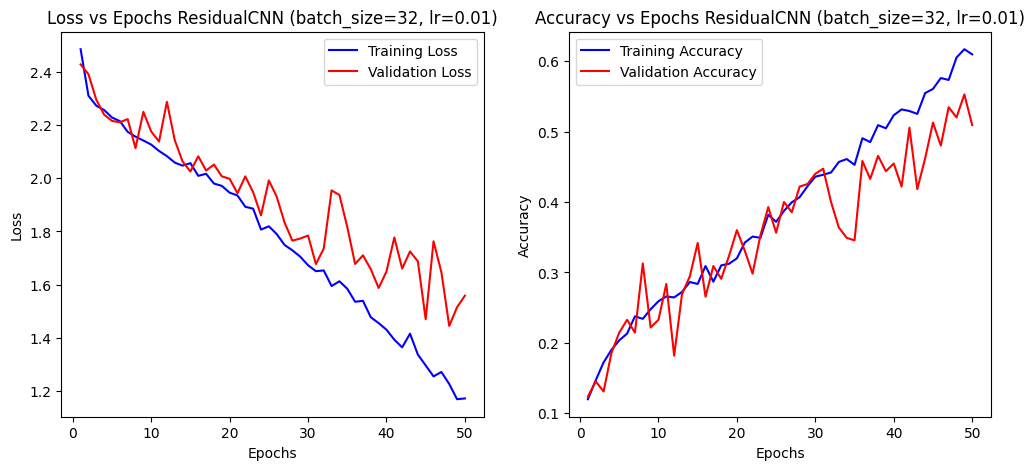


Training BasicCNN with batch_size=32, lr=0.001
Epoch [1/50] Train Loss: 2.2365 Val Loss: 2.2897 Train Acc: 0.2018 Val Acc: 0.1636
Epoch [2/50] Train Loss: 2.0766 Val Loss: 2.1664 Train Acc: 0.2709 Val Acc: 0.2655
Epoch [3/50] Train Loss: 1.9865 Val Loss: 1.9456 Train Acc: 0.3114 Val Acc: 0.3309
Epoch [4/50] Train Loss: 1.9187 Val Loss: 1.8854 Train Acc: 0.3286 Val Acc: 0.3345
Epoch [5/50] Train Loss: 1.8410 Val Loss: 2.0315 Train Acc: 0.3591 Val Acc: 0.2909
Epoch [6/50] Train Loss: 1.8062 Val Loss: 1.8981 Train Acc: 0.3855 Val Acc: 0.3964
Epoch [7/50] Train Loss: 1.7580 Val Loss: 1.8197 Train Acc: 0.3941 Val Acc: 0.4145
Epoch [8/50] Train Loss: 1.7438 Val Loss: 1.8066 Train Acc: 0.4018 Val Acc: 0.4291
Epoch [9/50] Train Loss: 1.6745 Val Loss: 1.6873 Train Acc: 0.4400 Val Acc: 0.4473
Epoch [10/50] Train Loss: 1.6304 Val Loss: 1.7555 Train Acc: 0.4436 Val Acc: 0.4218
Epoch [11/50] Train Loss: 1.5583 Val Loss: 1.7786 Train Acc: 0.4668 Val Acc: 0.4073
Epoch [12/50] Train Loss: 1.5275 Val 

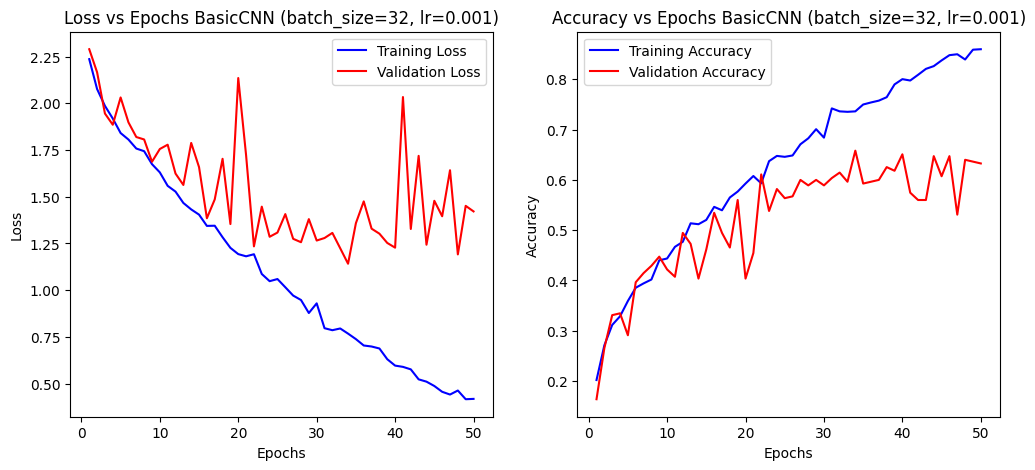


Training ResidualCNN with batch_size=32, lr=0.001
Epoch [1/50] Train Loss: 2.2911 Val Loss: 2.2918 Train Acc: 0.1805 Val Acc: 0.2073
Epoch [2/50] Train Loss: 2.1765 Val Loss: 2.2334 Train Acc: 0.2314 Val Acc: 0.2400
Epoch [3/50] Train Loss: 2.0894 Val Loss: 2.1195 Train Acc: 0.2741 Val Acc: 0.2727
Epoch [4/50] Train Loss: 2.0454 Val Loss: 2.0110 Train Acc: 0.2968 Val Acc: 0.3055
Epoch [5/50] Train Loss: 1.9816 Val Loss: 2.0821 Train Acc: 0.3286 Val Acc: 0.3127
Epoch [6/50] Train Loss: 1.9423 Val Loss: 2.0524 Train Acc: 0.3414 Val Acc: 0.3345
Epoch [7/50] Train Loss: 1.8788 Val Loss: 1.9213 Train Acc: 0.3536 Val Acc: 0.3418
Epoch [8/50] Train Loss: 1.8677 Val Loss: 2.0541 Train Acc: 0.3668 Val Acc: 0.2945
Epoch [9/50] Train Loss: 1.8379 Val Loss: 1.7245 Train Acc: 0.3595 Val Acc: 0.4291
Epoch [10/50] Train Loss: 1.7981 Val Loss: 1.9673 Train Acc: 0.3841 Val Acc: 0.3455
Epoch [11/50] Train Loss: 1.7810 Val Loss: 1.7293 Train Acc: 0.4055 Val Acc: 0.4436
Epoch [12/50] Train Loss: 1.7240 V

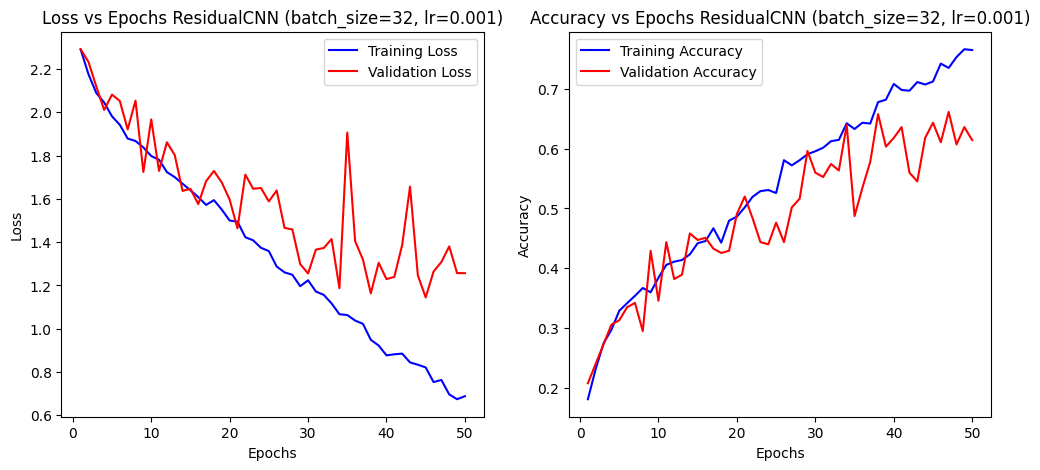


Training BasicCNN with batch_size=64, lr=0.1
Epoch [1/50] Train Loss: 11.3339 Val Loss: 4.4269 Train Acc: 0.0909 Val Acc: 0.1091
Epoch [2/50] Train Loss: 2.4044 Val Loss: 2.3999 Train Acc: 0.1023 Val Acc: 0.1055
Epoch [3/50] Train Loss: 2.3865 Val Loss: 2.3861 Train Acc: 0.1105 Val Acc: 0.0982
Epoch [4/50] Train Loss: 2.3683 Val Loss: 2.3733 Train Acc: 0.1250 Val Acc: 0.1091
Epoch [5/50] Train Loss: 2.3654 Val Loss: 2.3709 Train Acc: 0.1177 Val Acc: 0.0945
Epoch [6/50] Train Loss: 2.3477 Val Loss: 2.3553 Train Acc: 0.1059 Val Acc: 0.1236
Epoch [7/50] Train Loss: 2.3378 Val Loss: 2.3637 Train Acc: 0.1409 Val Acc: 0.1273
Epoch [8/50] Train Loss: 2.3272 Val Loss: 2.3605 Train Acc: 0.1305 Val Acc: 0.1273
Epoch [9/50] Train Loss: 2.2988 Val Loss: 2.3506 Train Acc: 0.1391 Val Acc: 0.1273
Epoch [10/50] Train Loss: 2.3303 Val Loss: 2.3671 Train Acc: 0.1195 Val Acc: 0.1345
Epoch [11/50] Train Loss: 2.3241 Val Loss: 2.3562 Train Acc: 0.1395 Val Acc: 0.1418
Epoch [12/50] Train Loss: 2.3008 Val L

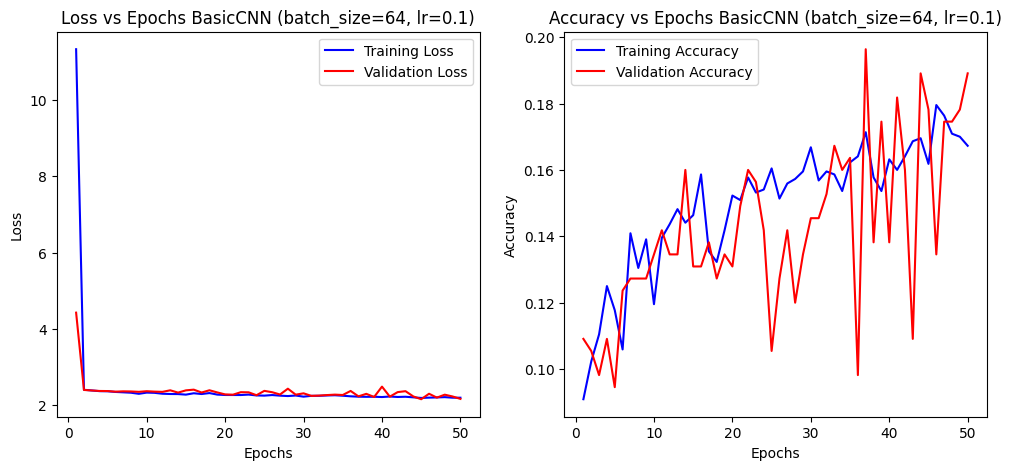


Training ResidualCNN with batch_size=64, lr=0.1
Epoch [1/50] Train Loss: 11.9940 Val Loss: 3.0984 Train Acc: 0.0882 Val Acc: 0.0800
Epoch [2/50] Train Loss: 2.4074 Val Loss: 2.4066 Train Acc: 0.0991 Val Acc: 0.0909
Epoch [3/50] Train Loss: 2.3985 Val Loss: 2.4036 Train Acc: 0.1027 Val Acc: 0.1018
Epoch [4/50] Train Loss: 2.3729 Val Loss: 2.3893 Train Acc: 0.1282 Val Acc: 0.1236
Epoch [5/50] Train Loss: 2.3436 Val Loss: 2.3584 Train Acc: 0.1355 Val Acc: 0.1236
Epoch [6/50] Train Loss: 2.3139 Val Loss: 2.3562 Train Acc: 0.1373 Val Acc: 0.1673
Epoch [7/50] Train Loss: 2.3055 Val Loss: 2.3464 Train Acc: 0.1491 Val Acc: 0.1491
Epoch [8/50] Train Loss: 2.2990 Val Loss: 2.3512 Train Acc: 0.1568 Val Acc: 0.1273
Epoch [9/50] Train Loss: 2.2866 Val Loss: 2.3234 Train Acc: 0.1559 Val Acc: 0.1382
Epoch [10/50] Train Loss: 2.2952 Val Loss: 2.3432 Train Acc: 0.1455 Val Acc: 0.1309
Epoch [11/50] Train Loss: 2.2833 Val Loss: 2.2982 Train Acc: 0.1586 Val Acc: 0.1491
Epoch [12/50] Train Loss: 2.2771 Va

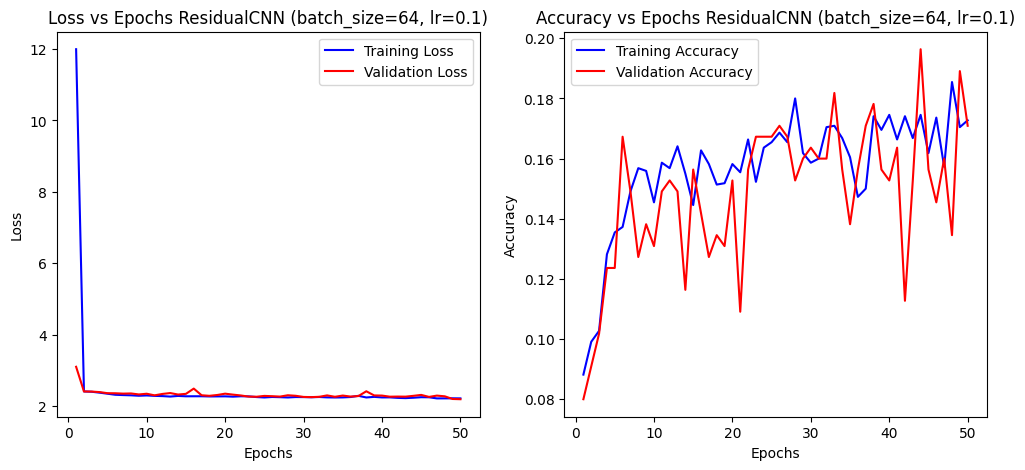


Training BasicCNN with batch_size=64, lr=0.01
Epoch [1/50] Train Loss: 2.4634 Val Loss: 3.4121 Train Acc: 0.1227 Val Acc: 0.1018
Epoch [2/50] Train Loss: 2.2662 Val Loss: 2.3107 Train Acc: 0.1845 Val Acc: 0.1673
Epoch [3/50] Train Loss: 2.2533 Val Loss: 2.2510 Train Acc: 0.1827 Val Acc: 0.1964
Epoch [4/50] Train Loss: 2.2100 Val Loss: 2.3150 Train Acc: 0.2023 Val Acc: 0.2073
Epoch [5/50] Train Loss: 2.1983 Val Loss: 2.3782 Train Acc: 0.2045 Val Acc: 0.1527
Epoch [6/50] Train Loss: 2.1772 Val Loss: 2.3841 Train Acc: 0.2164 Val Acc: 0.1564
Epoch [7/50] Train Loss: 2.1581 Val Loss: 2.2345 Train Acc: 0.2250 Val Acc: 0.2255
Epoch [8/50] Train Loss: 2.0880 Val Loss: 2.1667 Train Acc: 0.2555 Val Acc: 0.2509
Epoch [9/50] Train Loss: 2.0914 Val Loss: 2.1854 Train Acc: 0.2655 Val Acc: 0.2582
Epoch [10/50] Train Loss: 2.0409 Val Loss: 2.2806 Train Acc: 0.2982 Val Acc: 0.2545
Epoch [11/50] Train Loss: 2.0119 Val Loss: 1.9480 Train Acc: 0.3064 Val Acc: 0.3455
Epoch [12/50] Train Loss: 1.9436 Val L

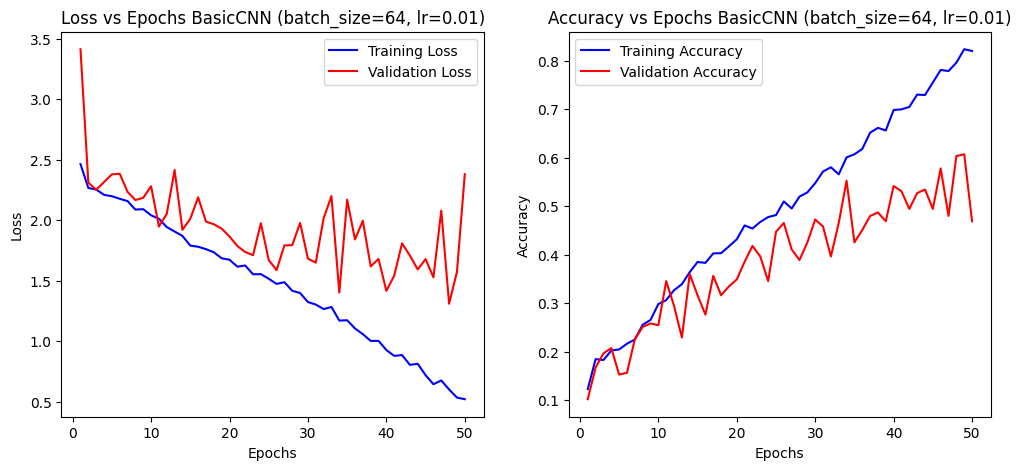


Training ResidualCNN with batch_size=64, lr=0.01
Epoch [1/50] Train Loss: 2.5107 Val Loss: 2.5582 Train Acc: 0.1232 Val Acc: 0.1200
Epoch [2/50] Train Loss: 2.2785 Val Loss: 2.2980 Train Acc: 0.1714 Val Acc: 0.1855
Epoch [3/50] Train Loss: 2.2780 Val Loss: 2.3329 Train Acc: 0.1700 Val Acc: 0.1527
Epoch [4/50] Train Loss: 2.2416 Val Loss: 2.2423 Train Acc: 0.1873 Val Acc: 0.1818
Epoch [5/50] Train Loss: 2.2254 Val Loss: 2.2270 Train Acc: 0.2100 Val Acc: 0.2036
Epoch [6/50] Train Loss: 2.1968 Val Loss: 2.2025 Train Acc: 0.2150 Val Acc: 0.2109
Epoch [7/50] Train Loss: 2.1821 Val Loss: 2.2694 Train Acc: 0.2132 Val Acc: 0.1818
Epoch [8/50] Train Loss: 2.1840 Val Loss: 2.1873 Train Acc: 0.2168 Val Acc: 0.2255
Epoch [9/50] Train Loss: 2.1549 Val Loss: 2.1566 Train Acc: 0.2255 Val Acc: 0.2545
Epoch [10/50] Train Loss: 2.1300 Val Loss: 2.3537 Train Acc: 0.2514 Val Acc: 0.1564
Epoch [11/50] Train Loss: 2.0993 Val Loss: 2.2057 Train Acc: 0.2668 Val Acc: 0.2618
Epoch [12/50] Train Loss: 2.0830 Va

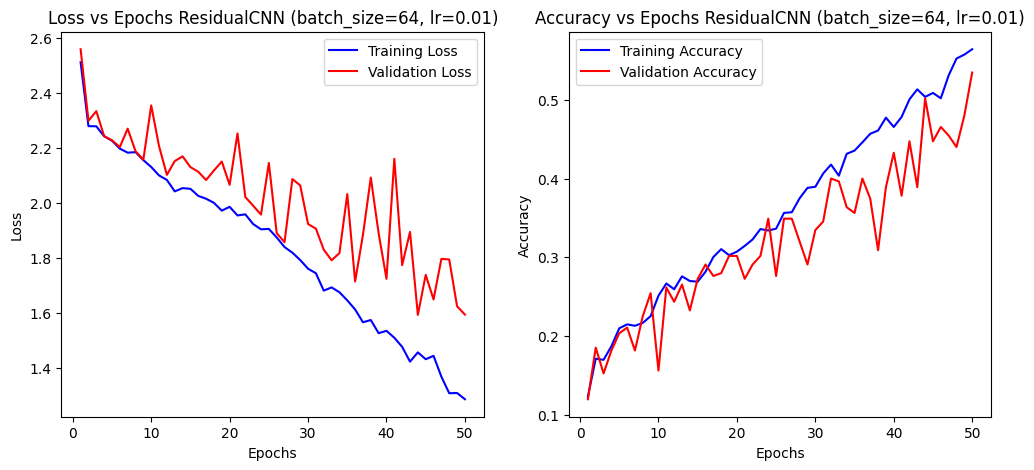


Training BasicCNN with batch_size=64, lr=0.001
Epoch [1/50] Train Loss: 2.2506 Val Loss: 2.2344 Train Acc: 0.1900 Val Acc: 0.2036
Epoch [2/50] Train Loss: 2.0777 Val Loss: 2.1699 Train Acc: 0.2832 Val Acc: 0.2800
Epoch [3/50] Train Loss: 1.9632 Val Loss: 2.2563 Train Acc: 0.3209 Val Acc: 0.2727
Epoch [4/50] Train Loss: 1.9232 Val Loss: 1.8616 Train Acc: 0.3386 Val Acc: 0.3600
Epoch [5/50] Train Loss: 1.8731 Val Loss: 1.8889 Train Acc: 0.3459 Val Acc: 0.3345
Epoch [6/50] Train Loss: 1.8029 Val Loss: 2.0380 Train Acc: 0.3695 Val Acc: 0.3745
Epoch [7/50] Train Loss: 1.7283 Val Loss: 1.9005 Train Acc: 0.4109 Val Acc: 0.3491
Epoch [8/50] Train Loss: 1.6766 Val Loss: 1.8577 Train Acc: 0.4195 Val Acc: 0.3600
Epoch [9/50] Train Loss: 1.6760 Val Loss: 1.7241 Train Acc: 0.4318 Val Acc: 0.4073
Epoch [10/50] Train Loss: 1.6095 Val Loss: 2.1615 Train Acc: 0.4582 Val Acc: 0.3309
Epoch [11/50] Train Loss: 1.5698 Val Loss: 1.8599 Train Acc: 0.4750 Val Acc: 0.3636
Epoch [12/50] Train Loss: 1.4979 Val 

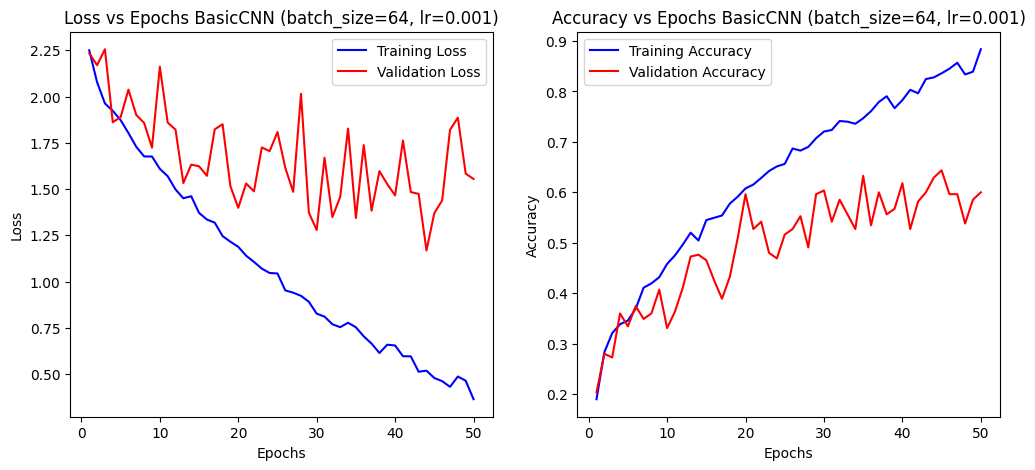


Training ResidualCNN with batch_size=64, lr=0.001
Epoch [1/50] Train Loss: 2.2944 Val Loss: 2.6692 Train Acc: 0.1814 Val Acc: 0.1564
Epoch [2/50] Train Loss: 2.1631 Val Loss: 2.1512 Train Acc: 0.2514 Val Acc: 0.2509
Epoch [3/50] Train Loss: 2.0632 Val Loss: 2.0401 Train Acc: 0.2845 Val Acc: 0.3018
Epoch [4/50] Train Loss: 1.9937 Val Loss: 2.0926 Train Acc: 0.3177 Val Acc: 0.3127
Epoch [5/50] Train Loss: 1.9389 Val Loss: 1.9971 Train Acc: 0.3300 Val Acc: 0.3091
Epoch [6/50] Train Loss: 1.8581 Val Loss: 2.0027 Train Acc: 0.3564 Val Acc: 0.3200
Epoch [7/50] Train Loss: 1.8067 Val Loss: 2.1235 Train Acc: 0.3905 Val Acc: 0.3564
Epoch [8/50] Train Loss: 1.7728 Val Loss: 2.1524 Train Acc: 0.3945 Val Acc: 0.3527
Epoch [9/50] Train Loss: 1.7435 Val Loss: 1.9647 Train Acc: 0.4114 Val Acc: 0.3382
Epoch [10/50] Train Loss: 1.6923 Val Loss: 2.3059 Train Acc: 0.4255 Val Acc: 0.3418
Epoch [11/50] Train Loss: 1.6523 Val Loss: 1.9251 Train Acc: 0.4368 Val Acc: 0.3636
Epoch [12/50] Train Loss: 1.6365 V

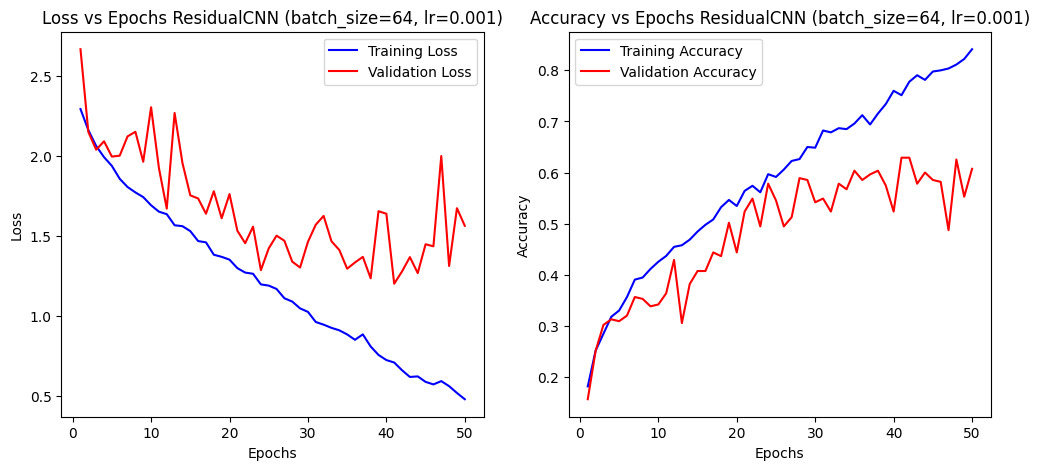

In [9]:
# Step 5.3: Full Training Loop

learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [32, 64]

num_epochs = 50

results = {}

for batch_size in batch_sizes:
    # DataLoader'ı yeniden tanımlıyoruz batch size değişince
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for lr in learning_rates:
        print(f"\nTraining BasicCNN with batch_size={batch_size}, lr={lr}")
        
        model_basic = BasicCNN(num_classes=11).to(device)
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model_basic, train_loader, val_loader, learning_rate=lr, num_epochs=num_epochs
        )
        
        title = f"BasicCNN (batch_size={batch_size}, lr={lr})"
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title_suffix=title)
        
        results[f"BasicCNN_bs{batch_size}_lr{lr}"] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "model": model_basic
        }
        
        print(f"\nTraining ResidualCNN with batch_size={batch_size}, lr={lr}")
        
        model_residual = ResidualCNN(num_classes=11).to(device)
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model_residual, train_loader, val_loader, learning_rate=lr, num_epochs=num_epochs
        )
        
        title = f"ResidualCNN (batch_size={batch_size}, lr={lr})"
        plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title_suffix=title)
        
        results[f"ResidualCNN_bs{batch_size}_lr{lr}"] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "model": model_residual
        }


In [11]:
# Step 6.1: Find Best Model According to Validation Accuracy

def find_best_model(results, model_type):
    best_val_acc = 0.0
    best_key = None
    for key, value in results.items():
        if model_type in key:
            val_accuracies = value["val_accuracies"]
            max_val_acc = max(val_accuracies)
            if max_val_acc > best_val_acc:
                best_val_acc = max_val_acc
                best_key = key
    return best_key, best_val_acc


In [12]:
# Step 6.2: Select Best Models

best_basic_key, best_basic_val_acc = find_best_model(results, "BasicCNN")
best_residual_key, best_residual_val_acc = find_best_model(results, "ResidualCNN")

print(f"Best BasicCNN Model: {best_basic_key} with Validation Accuracy: {best_basic_val_acc:.4f}")
print(f"Best ResidualCNN Model: {best_residual_key} with Validation Accuracy: {best_residual_val_acc:.4f}")

best_basic_model = results[best_basic_key]["model"]
best_residual_model = results[best_residual_key]["model"]


Best BasicCNN Model: BasicCNN_bs32_lr0.001 with Validation Accuracy: 0.6582
Best ResidualCNN Model: ResidualCNN_bs32_lr0.001 with Validation Accuracy: 0.6618


In [14]:
# Step 7: Test Best Models on Test Set

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_loss_basic, test_acc_basic = evaluate(best_basic_model, test_loader, device)
print(f"Test Accuracy for Best BasicCNN: {test_acc_basic:.4f}")

test_loss_residual, test_acc_residual = evaluate(best_residual_model, test_loader, device)
print(f"Test Accuracy for Best ResidualCNN: {test_acc_residual:.4f}")


Test Accuracy for Best BasicCNN: 0.4764
Test Accuracy for Best ResidualCNN: 0.5018


In [15]:
# Step 8.1: BasicCNN with Dropout

class BasicCNN_Dropout(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.5):
        super(BasicCNN_Dropout, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [16]:
# Step 8.2: ResidualCNN with Dropout

class ResidualCNN_Dropout(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.5):
        super(ResidualCNN_Dropout, self).__init__()
        
        self.layer1 = ResidualBlock(3, 32)
        self.layer2 = ResidualBlock(32, 64, downsample=True)
        self.layer3 = ResidualBlock(64, 128, downsample=True)
        self.layer4 = ResidualBlock(128, 256, downsample=True)
        self.layer5 = ResidualBlock(256, 512, downsample=True)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



Training BasicCNN_Dropout with dropout=0.3
Epoch [1/50] Train Loss: 2.2763 Val Loss: 2.1399 Train Acc: 0.1882 Val Acc: 0.2545
Epoch [2/50] Train Loss: 2.1353 Val Loss: 2.0937 Train Acc: 0.2468 Val Acc: 0.2436
Epoch [3/50] Train Loss: 2.0655 Val Loss: 2.1419 Train Acc: 0.2750 Val Acc: 0.2945
Epoch [4/50] Train Loss: 1.9994 Val Loss: 1.9756 Train Acc: 0.2968 Val Acc: 0.2909
Epoch [5/50] Train Loss: 1.9503 Val Loss: 1.9542 Train Acc: 0.3145 Val Acc: 0.3455
Epoch [6/50] Train Loss: 1.9394 Val Loss: 1.9757 Train Acc: 0.3486 Val Acc: 0.3564
Epoch [7/50] Train Loss: 1.8665 Val Loss: 1.7748 Train Acc: 0.3723 Val Acc: 0.4109
Epoch [8/50] Train Loss: 1.7976 Val Loss: 2.0288 Train Acc: 0.3841 Val Acc: 0.3200
Epoch [9/50] Train Loss: 1.7982 Val Loss: 1.9024 Train Acc: 0.3959 Val Acc: 0.3564
Epoch [10/50] Train Loss: 1.7185 Val Loss: 1.7837 Train Acc: 0.4100 Val Acc: 0.3927
Epoch [11/50] Train Loss: 1.7116 Val Loss: 1.6526 Train Acc: 0.4141 Val Acc: 0.4364
Epoch [12/50] Train Loss: 1.6491 Val Loss

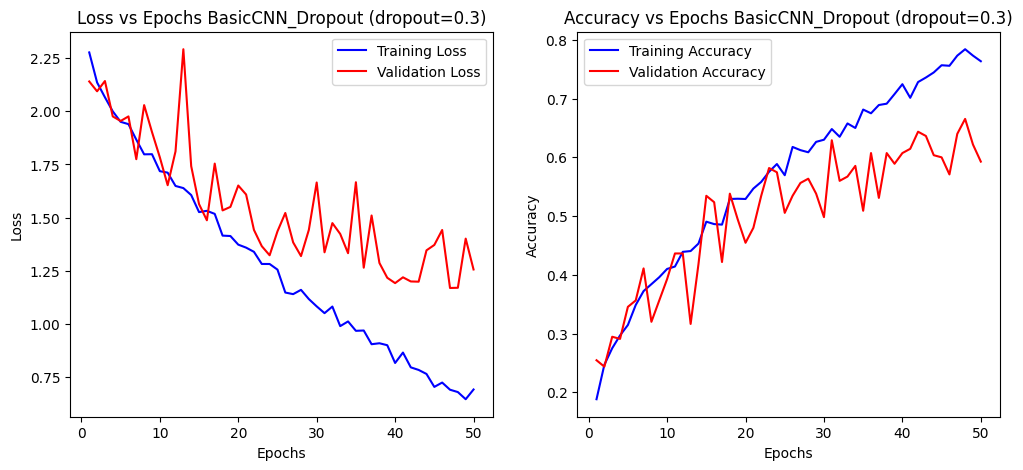


Training ResidualCNN_Dropout with dropout=0.3
Epoch [1/50] Train Loss: 2.3251 Val Loss: 2.3588 Train Acc: 0.1536 Val Acc: 0.1418
Epoch [2/50] Train Loss: 2.2058 Val Loss: 2.1947 Train Acc: 0.2268 Val Acc: 0.2400
Epoch [3/50] Train Loss: 2.1402 Val Loss: 2.1314 Train Acc: 0.2505 Val Acc: 0.2436
Epoch [4/50] Train Loss: 2.0997 Val Loss: 2.2569 Train Acc: 0.2600 Val Acc: 0.2473
Epoch [5/50] Train Loss: 2.0742 Val Loss: 2.0131 Train Acc: 0.2750 Val Acc: 0.3164
Epoch [6/50] Train Loss: 1.9995 Val Loss: 1.9462 Train Acc: 0.2950 Val Acc: 0.3200
Epoch [7/50] Train Loss: 1.9692 Val Loss: 1.9587 Train Acc: 0.3182 Val Acc: 0.3382
Epoch [8/50] Train Loss: 1.9462 Val Loss: 1.9883 Train Acc: 0.3205 Val Acc: 0.3455
Epoch [9/50] Train Loss: 1.9199 Val Loss: 1.8428 Train Acc: 0.3355 Val Acc: 0.3345
Epoch [10/50] Train Loss: 1.8827 Val Loss: 1.7799 Train Acc: 0.3536 Val Acc: 0.4145
Epoch [11/50] Train Loss: 1.8308 Val Loss: 1.8525 Train Acc: 0.3841 Val Acc: 0.4000
Epoch [12/50] Train Loss: 1.7943 Val L

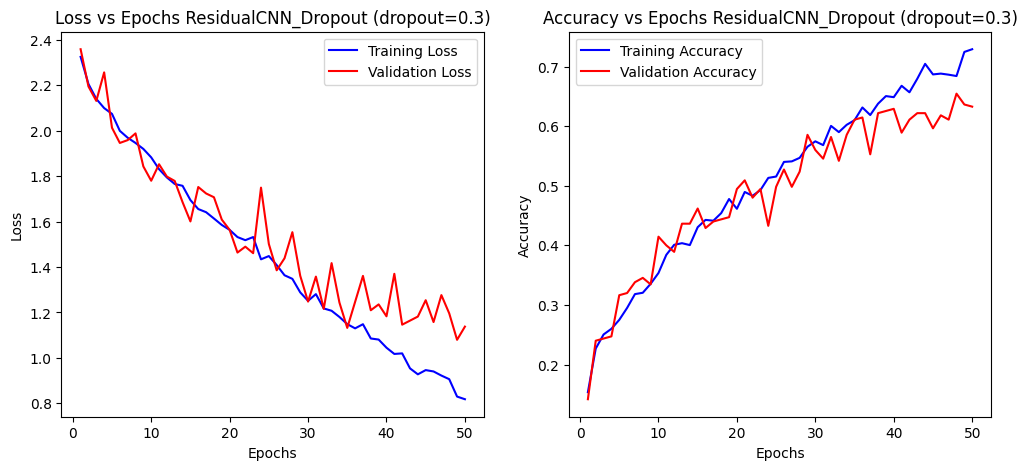


Training BasicCNN_Dropout with dropout=0.5
Epoch [1/50] Train Loss: 2.2887 Val Loss: 2.1947 Train Acc: 0.1895 Val Acc: 0.2000
Epoch [2/50] Train Loss: 2.1557 Val Loss: 2.1970 Train Acc: 0.2323 Val Acc: 0.1855
Epoch [3/50] Train Loss: 2.0801 Val Loss: 2.0852 Train Acc: 0.2550 Val Acc: 0.2655
Epoch [4/50] Train Loss: 2.0539 Val Loss: 2.0594 Train Acc: 0.2864 Val Acc: 0.3055
Epoch [5/50] Train Loss: 1.9946 Val Loss: 1.9015 Train Acc: 0.3141 Val Acc: 0.3055
Epoch [6/50] Train Loss: 1.9630 Val Loss: 2.0339 Train Acc: 0.3200 Val Acc: 0.2473
Epoch [7/50] Train Loss: 1.9011 Val Loss: 2.0965 Train Acc: 0.3341 Val Acc: 0.2655
Epoch [8/50] Train Loss: 1.8705 Val Loss: 1.8069 Train Acc: 0.3595 Val Acc: 0.3673
Epoch [9/50] Train Loss: 1.8274 Val Loss: 1.7241 Train Acc: 0.3714 Val Acc: 0.4218
Epoch [10/50] Train Loss: 1.7763 Val Loss: 1.6794 Train Acc: 0.4082 Val Acc: 0.4182
Epoch [11/50] Train Loss: 1.7462 Val Loss: 1.7667 Train Acc: 0.4045 Val Acc: 0.4145
Epoch [12/50] Train Loss: 1.7420 Val Loss

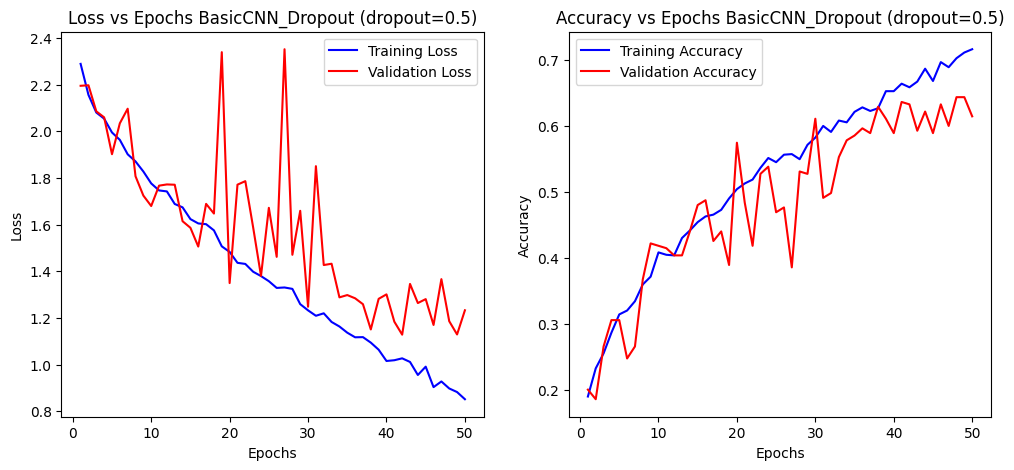


Training ResidualCNN_Dropout with dropout=0.5
Epoch [1/50] Train Loss: 2.3394 Val Loss: 2.2925 Train Acc: 0.1609 Val Acc: 0.1564
Epoch [2/50] Train Loss: 2.2386 Val Loss: 2.2570 Train Acc: 0.1895 Val Acc: 0.2327
Epoch [3/50] Train Loss: 2.2029 Val Loss: 2.1981 Train Acc: 0.2200 Val Acc: 0.2218
Epoch [4/50] Train Loss: 2.1496 Val Loss: 2.1466 Train Acc: 0.2532 Val Acc: 0.2509
Epoch [5/50] Train Loss: 2.1074 Val Loss: 2.0661 Train Acc: 0.2586 Val Acc: 0.2909
Epoch [6/50] Train Loss: 2.0756 Val Loss: 2.1250 Train Acc: 0.2618 Val Acc: 0.2364
Epoch [7/50] Train Loss: 2.0626 Val Loss: 2.0162 Train Acc: 0.2827 Val Acc: 0.3055
Epoch [8/50] Train Loss: 2.0142 Val Loss: 2.0065 Train Acc: 0.2868 Val Acc: 0.3309
Epoch [9/50] Train Loss: 1.9886 Val Loss: 2.0436 Train Acc: 0.2941 Val Acc: 0.3091
Epoch [10/50] Train Loss: 1.9883 Val Loss: 2.0395 Train Acc: 0.3077 Val Acc: 0.3055
Epoch [11/50] Train Loss: 1.9885 Val Loss: 1.9473 Train Acc: 0.3259 Val Acc: 0.2945
Epoch [12/50] Train Loss: 1.9006 Val L

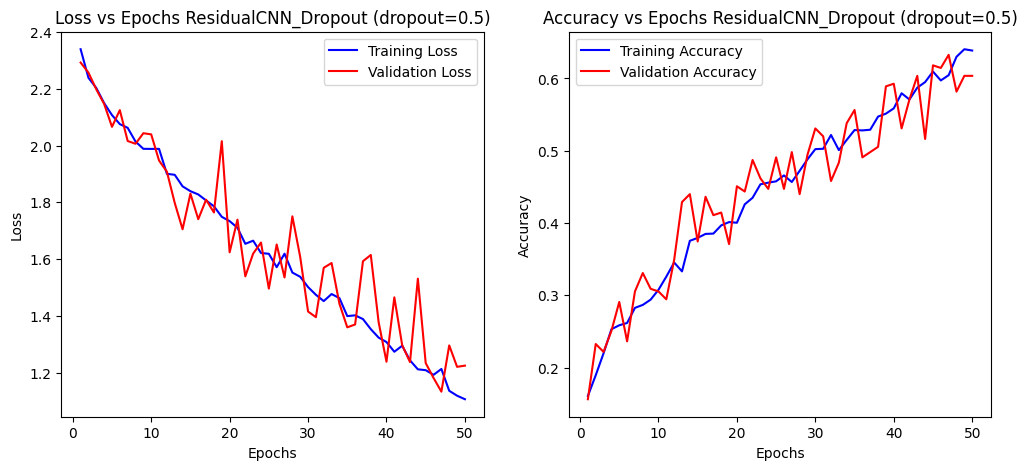

In [17]:
# Step 9.1: Train Dropout Models

dropout_rates = [0.3, 0.5]

dropout_results = {}

for dropout_rate in dropout_rates:
    print(f"\nTraining BasicCNN_Dropout with dropout={dropout_rate}")
    
    model_basic_dropout = BasicCNN_Dropout(num_classes=11, dropout_rate=dropout_rate).to(device)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model_basic_dropout, train_loader, val_loader, learning_rate=0.001, num_epochs=50
    )
    
    title = f"BasicCNN_Dropout (dropout={dropout_rate})"
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title_suffix=title)
    
    dropout_results[f"BasicCNN_dropout{dropout_rate}"] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "model": model_basic_dropout
    }
    
    print(f"\nTraining ResidualCNN_Dropout with dropout={dropout_rate}")
    
    model_residual_dropout = ResidualCNN_Dropout(num_classes=11, dropout_rate=dropout_rate).to(device)
    
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model_residual_dropout, train_loader, val_loader, learning_rate=0.001, num_epochs=50
    )
    
    title = f"ResidualCNN_Dropout (dropout={dropout_rate})"
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title_suffix=title)
    
    dropout_results[f"ResidualCNN_dropout{dropout_rate}"] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "model": model_residual_dropout
    }


In [18]:
# Step 10: Evaluate Dropout Models on Test Set

for key, value in dropout_results.items():
    model = value["model"]
    test_loss, test_acc = evaluate(model, test_loader, device)
    print(f"Test Accuracy for {key}: {test_acc:.4f}")


Test Accuracy for BasicCNN_dropout0.3: 0.5345
Test Accuracy for ResidualCNN_dropout0.3: 0.5345
Test Accuracy for BasicCNN_dropout0.5: 0.5600
Test Accuracy for ResidualCNN_dropout0.5: 0.5236


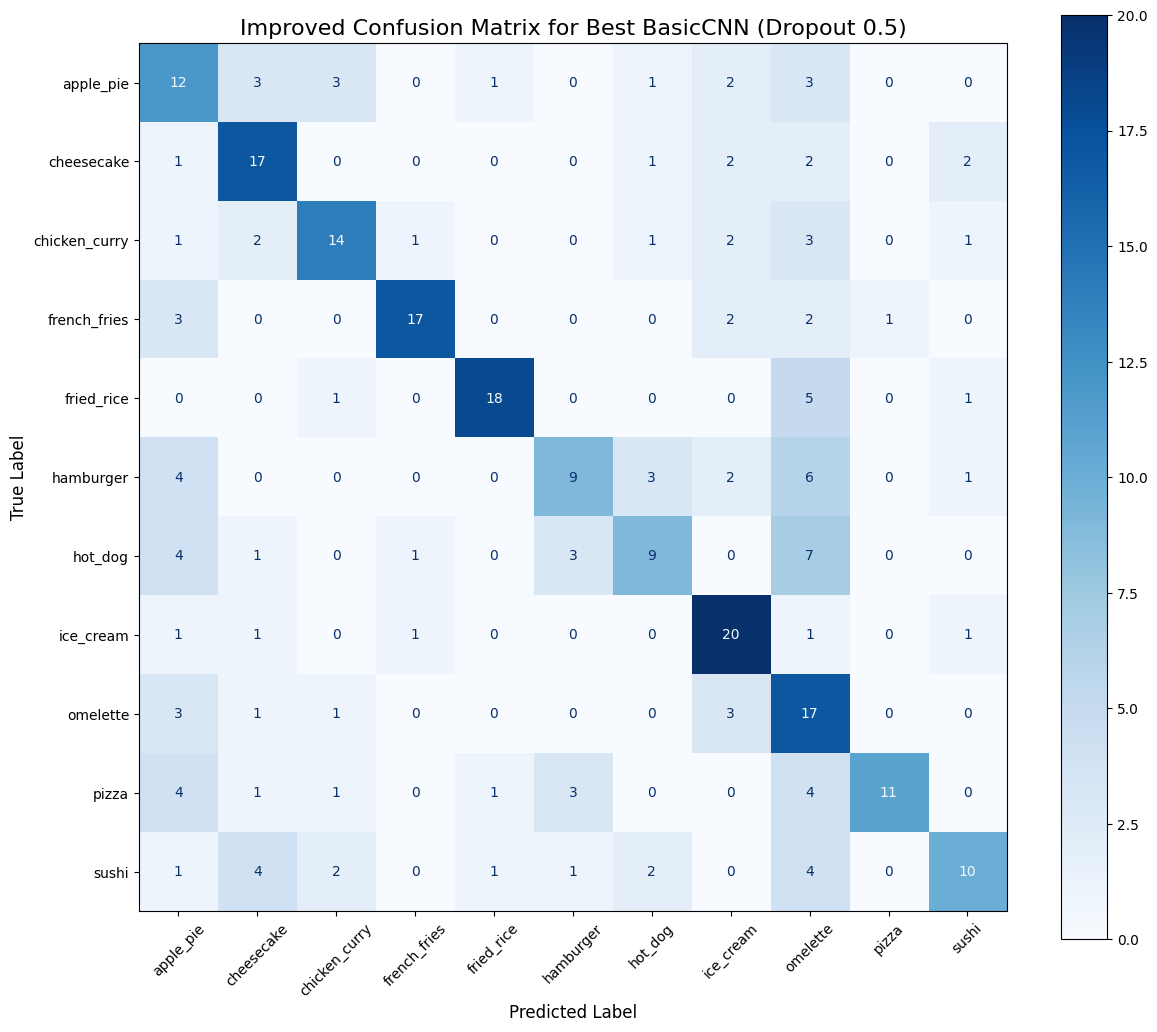

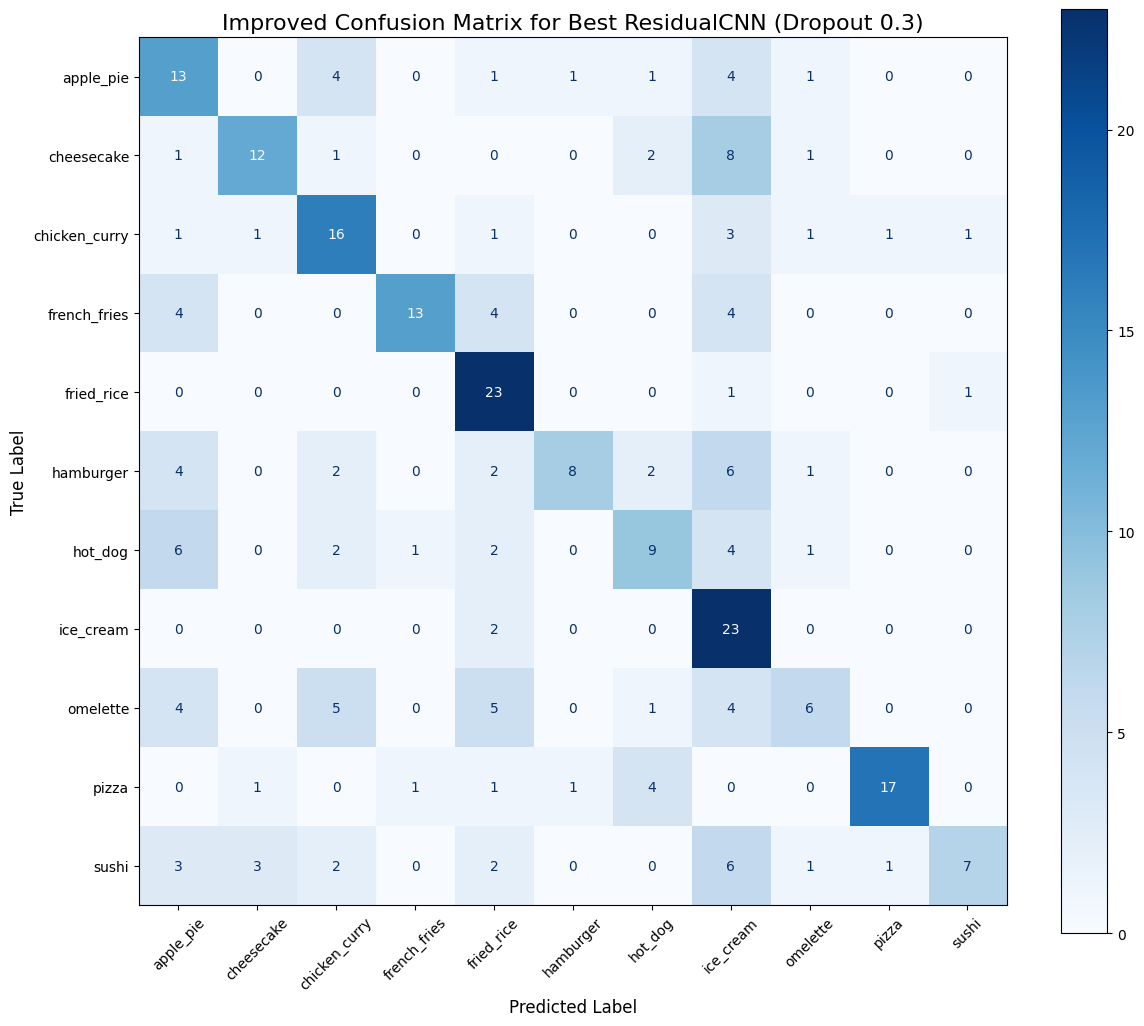

In [20]:
# Improved Confusion Matrix Drawing

def plot_confusion_improved(model, dataloader, class_names, device, title):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(14, 12))  # Büyük figür
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)  # X-axis yazıları 45 derece döndürülüyor
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

# Plot Improved Confusion Matrices

# Best BasicCNN Dropout Model
plot_confusion_improved(
    dropout_results["BasicCNN_dropout0.5"]["model"],
    test_loader,
    train_dataset.classes,
    device,
    title="Improved Confusion Matrix for Best BasicCNN (Dropout 0.5)"
)

# Best ResidualCNN Dropout Model
plot_confusion_improved(
    dropout_results["ResidualCNN_dropout0.3"]["model"],
    test_loader,
    train_dataset.classes,
    device,
    title="Improved Confusion Matrix for Best ResidualCNN (Dropout 0.3)"
)


In [21]:
# Step 13.1: Import Pre-trained MobileNetV2

import torchvision.models as models

def get_mobilenet_v2_model(num_classes=11):
    model = models.mobilenet_v2(pretrained=True)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last FC layer
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    
    return model.to(device)


In [22]:
# Step 13.2: Fine-tuning Train Function

def train_model_transfer(model, train_loader, val_loader, learning_rate=0.001, num_epochs=30):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_acc += acc * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_acc / len(train_loader.dataset)
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss, val_acc = evaluate(model, val_loader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {epoch_loss:.4f} Val Loss: {val_loss:.4f} "
                  f"Train Acc: {epoch_acc:.4f} Val Acc: {val_acc:.4f}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


c:\Users\Ali Buğra Sarıkaya\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ali Buğra Sarıkaya\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [10/30] Train Loss: 0.8495 Val Loss: 0.7601 Train Acc: 0.7327 Val Acc: 0.7564
Epoch [20/30] Train Loss: 0.7794 Val Loss: 0.7768 Train Acc: 0.7409 Val Acc: 0.7273
Epoch [30/30] Train Loss: 0.7785 Val Loss: 0.7694 Train Acc: 0.7264 Val Acc: 0.7636


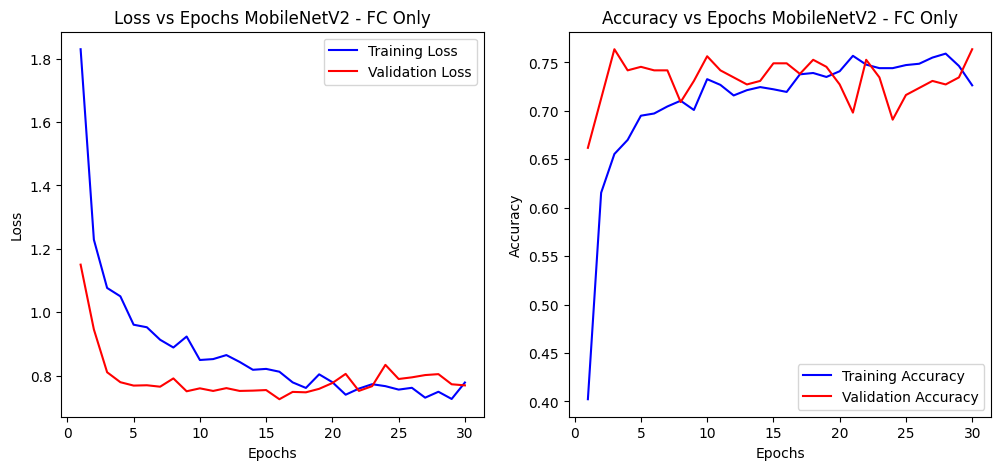

Test Accuracy (FC Only): 0.6727


In [ ]:
# Step 13.3: Case 1 - Only FC Layer Training

mobilenet_case1 = get_mobilenet_v2_model(num_classes=11)

# Batch Size ve Loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies = train_model_transfer(
    mobilenet_case1, train_loader, val_loader, learning_rate=0.001, num_epochs=30
)

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title_suffix="MobileNetV2 - FC Only")

# Test Accuracy after Training
test_loss, test_acc = evaluate(mobilenet_case1, test_loader, device)
print(f"Test Accuracy (FC Only): {test_acc:.4f}")


In [31]:
# Corrected Step: Unfreeze Last 2 Convolutional Blocks

def get_mobilenet_v2_last2conv_trainable(num_classes=11):
    model = models.mobilenet_v2(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # UNFREEZE: Only last two blocks
    for param in model.features[-2:].parameters():
        param.requires_grad = True

    # Replace and Unfreeze Classifier
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    return model.to(device)


In [32]:
mobilenet_case2 = get_mobilenet_v2_last2conv_trainable(num_classes=11)


Epoch [10/30] Train Loss: 0.3221 Val Loss: 0.7619 Train Acc: 0.8850 Val Acc: 0.7745
Epoch [20/30] Train Loss: 0.1713 Val Loss: 0.8934 Train Acc: 0.9473 Val Acc: 0.7564
Epoch [30/30] Train Loss: 0.1141 Val Loss: 1.0472 Train Acc: 0.9573 Val Acc: 0.7491


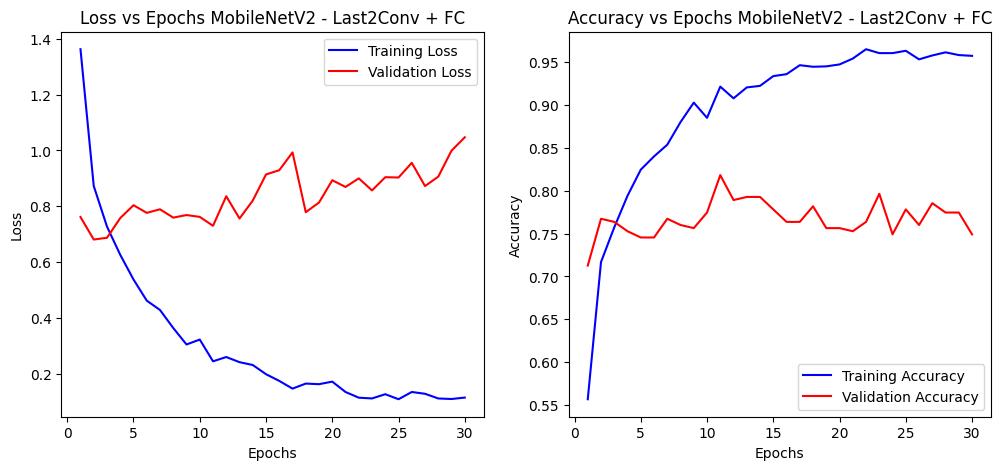

Test Accuracy (Last2Conv + FC): 0.7091


In [33]:
# Training MobileNetV2 with Last 2 Conv + FC

train_losses, val_losses, train_accuracies, val_accuracies = train_model_transfer(
    mobilenet_case2, train_loader, val_loader, learning_rate=0.0005, num_epochs=30
)

# Plotting the metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title_suffix="MobileNetV2 - Last2Conv + FC")

# Testing after training
test_loss, test_acc = evaluate(mobilenet_case2, test_loader, device)
print(f"Test Accuracy (Last2Conv + FC): {test_acc:.4f}")


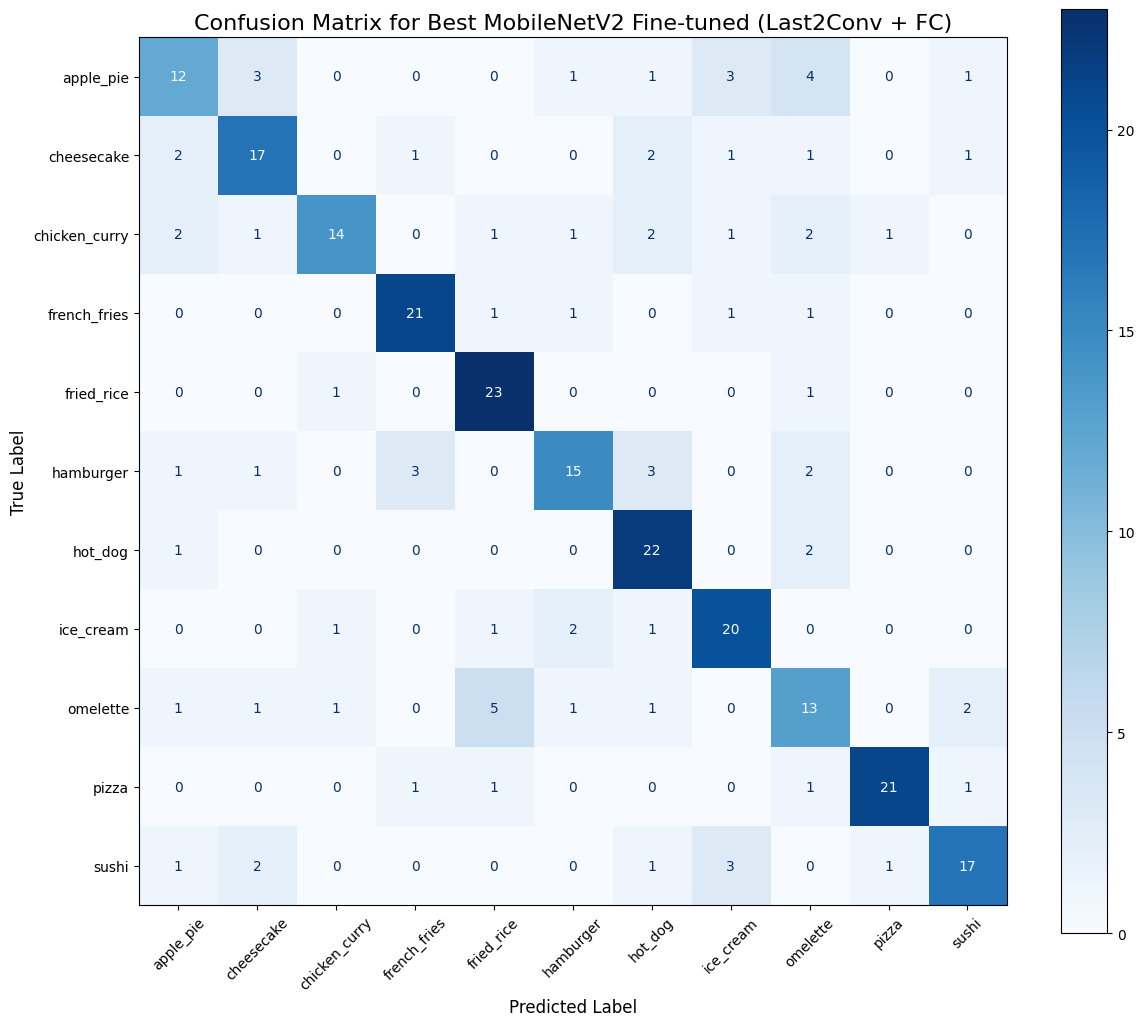

In [34]:
# Plot Confusion Matrix for Fine-tuned MobileNetV2

plot_confusion_improved(
    mobilenet_case2,
    test_loader,
    train_dataset.classes,
    device,
    title="Confusion Matrix for Best MobileNetV2 Fine-tuned (Last2Conv + FC)"
)
